## Part 1: Setup and Data Loading

In [44]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [45]:
import torch.utils


def load_binary_fashion_mnist(batch_size=64):
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Load full dataset, will automatically download to a 'data' subfolder.
    trainset = torchvision.datasets.FashionMNIST('./data', train=True,
                                                download=True, transform=transform)
    testset = torchvision.datasets.FashionMNIST('./data', train=False,
                                               download=True, transform=transform)
    
    # Filter dataset to keep only T-shirts (label 0) and Sneakers (label 9)
    train_idx = np.where((np.array(trainset.targets) == 0) | (np.array(trainset.targets) == 9))[0]
    test_idx = np.where((np.array(testset.targets) == 0) | (np.array(testset.targets) == 9))[0]
    
    # Create data loaders    
    # With Samplers
    # train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    # test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
    
    # trainloader = torch.utils.data.DataLoader(trainset, batch_size, sampler = train_sampler)
    # testloader = torch.utils.data.DataLoader(testset, batch_size, sampler = test_sampler)
    
    # With Subsets 
    train_subset = torch.utils.data.Subset(trainset, train_idx)
    test_subset = torch.utils.data.Subset(testset, test_idx)
    
    trainloader = torch.utils.data.DataLoader(train_subset, batch_size, True)
    testloader = torch.utils.data.DataLoader(test_subset, batch_size, True)
    

    return trainloader, testloader

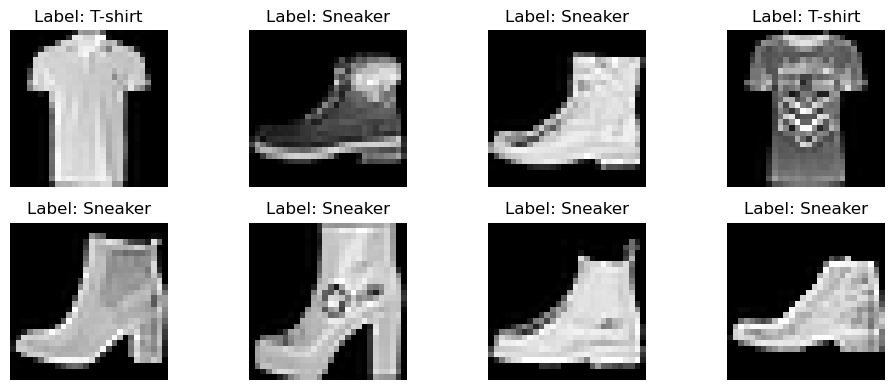

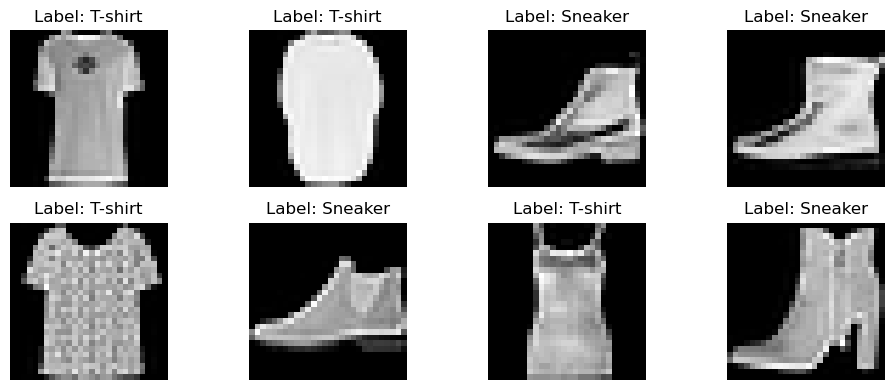

In [46]:
# Visualization function
def show_samples(dataloader):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(10, 4))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Label: {"Sneaker" if labels[i]==9 else "T-shirt"}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    

trainloader, testloader = load_binary_fashion_mnist(batch_size=64)
show_samples(trainloader)
show_samples(testloader)

## Part 2: Building a Neural Network from Scratch

In [48]:
class MLPFromScratch:
    def __init__(self, input_size=784):
        # Batch First
        # self.W1 = torch.normal(0, 0.01, size = (input_size, 512)) 
        # self.b1 = torch.zeros(512) 
        # self.W2 = torch.normal(0, 0.01, size = (512, 128)) 
        # self.b2 = torch.zeros(128) 
        # self.W3 = torch.normal(0, 0.01, size = (128, 1)) 
        # self.b3 = torch.zeros(1) 
        
        # Neuron First
        self.W1 = torch.normal(0, 0.01, size = (512, input_size)) 
        self.b1 = torch.zeros(512, 1) 
        self.W2 = torch.normal(0, 0.01, size = (128, 512)) 
        self.b2 = torch.zeros(128, 1) 
        self.W3 = torch.normal(0, 0.01, size = (1, 128)) 
        self.b3 = torch.zeros(1) 
        
        # Enable gradient tracking
        self.W1.requires_grad_(True)
        self.b1.requires_grad_(True)
        self.W2.requires_grad_(True)
        self.b2.requires_grad_(True)
        self.W3.requires_grad_(True)
        self.b3.requires_grad_(True)
    
    def forward(self, x):
        # Batch First
        # Hint: Use torch.matmul for matrix multiplication and torch.relu for ReLU activation
        # layer1_pre = torch.matmul(x, self.W1) + self.b1  (linear)
        # layer1_post = torch.relu(layer1_pre)  (ReLU)
        
        # layer2_pre = torch.matmul(layer1_post, self.W2) + self.b2  (linear)
        # layer2_post = torch.relu(layer2_pre)  (ReLU)
        
        # layer3_pre = torch.matmul(layer2_post, self.W3) + self.b3  (linear)
        # layer3_post = 1 / (1 + torch.exp(layer3_pre))  (sigmoid)
        
        # return layer3_post
        
        # Neuron First
        layer1_pre = torch.matmul(self.W1, x.T) + self.b1 # (linear)
        layer1_post = torch.relu(layer1_pre) # (ReLU)
        
        layer2_pre = torch.matmul(self.W2, layer1_post) + self.b2 # (linear)
        layer2_post = torch.relu(layer2_pre) # (ReLU)
        
        layer3_pre = torch.matmul(self.W3, layer2_post) + self.b3 # (linear)
        layer3_post = 1 / (1 + torch.exp(layer3_pre)) # (sigmoid)
        
        return layer3_post.T
    
    def parameters(self):
        return [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]

Batch 0, Loss: 0.6929
Batch 50, Loss: 0.6925
Batch 100, Loss: 0.6922
Batch 150, Loss: 0.6919


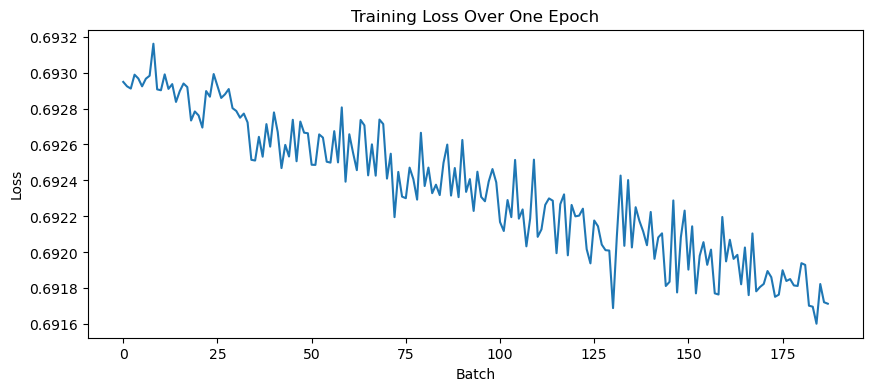

In [49]:
def train_one_epoch(model, trainloader, lr=0.001):
    criterion = nn.BCELoss()
    losses = []
    
    for i, (inputs, labels) in enumerate(trainloader):
        # Prepare data
        inputs = inputs.view(-1, 784)
        labels = (labels == 9).float().view(-1, 1)
        
        # Forward pass
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad
                param.grad.zero_()
                
        if i % 50 == 0:
            print(f'Batch {i}, Loss: {loss.item():.4f}')
    
    # Plot loss curve
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title('Training Loss Over One Epoch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()
    
trainloader, testloader = load_binary_fashion_mnist()
model = MLPFromScratch()
train_one_epoch(model, trainloader)

## Part 3: Using Bult-in Pytorch NN

In [32]:
class MLPWithNN(nn.Module):
    def __init__(self, input_size=784):
        super(MLPWithNN, self).__init__()
        self.network = nn.Sequential (
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x.view(-1, 784))

# Parameter Initialization Function
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.zeros_(m.bias)
        pass

In [42]:
def train_model(model, trainloader, testloader, epochs=10, lr=0.001):
    criterion = nn.BCELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in trainloader:
            inputs = inputs.view(-1, 784)
            labels = (labels == 9).float().view(-1, 1)
            
            optimizer.zero_grad()
            
            outputs = model.forward(inputs)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            loss.backward()
            
            optimizer.step()
            
        # Evaluate on test set after training for one epoch.
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.view(-1, 784)
                labels = (labels == 9).float().view(-1, 1)
                outputs = model(inputs)
                predictions = (outputs >= 0.5).float() 
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
        
        test_accuracy = correct / total * 100 
        test_accuracies.append(test_accuracy)
        train_losses.append(running_loss / len(trainloader))
        
        print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.show()

Epoch 1, Loss: 0.0289, Test Accuracy: 99.55%
Epoch 2, Loss: 0.0044, Test Accuracy: 99.55%
Epoch 3, Loss: 0.0012, Test Accuracy: 99.90%
Epoch 4, Loss: 0.0028, Test Accuracy: 99.95%
Epoch 5, Loss: 0.0016, Test Accuracy: 99.90%
Epoch 6, Loss: 0.0020, Test Accuracy: 99.85%
Epoch 7, Loss: 0.0005, Test Accuracy: 99.95%
Epoch 8, Loss: 0.0000, Test Accuracy: 99.95%
Epoch 9, Loss: 0.0000, Test Accuracy: 99.95%
Epoch 10, Loss: 0.0000, Test Accuracy: 99.95%


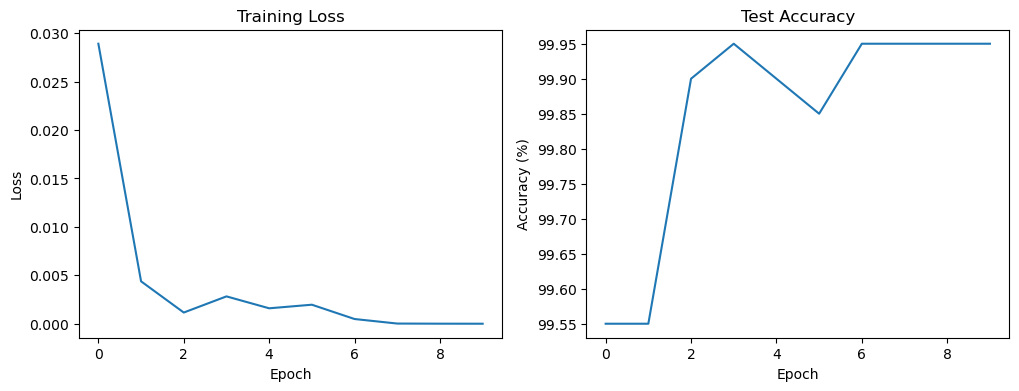

In [43]:
# Load data
trainloader, testloader = load_binary_fashion_mnist()

# Create and initialize model
model = MLPWithNN()
model.apply(init_weights)

# Train model
train_model(model, trainloader, testloader, epochs=10)